In [1]:
from mp_api.client import MPRester
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty, ElementFraction, Meredig, Stoichiometry
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_validate

from sklearn.svm import SVR
from xgboost import XGBRegressor

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

from pymatgen.core import Structure
import numpy as np
from typing import Dict, List, Optional, Union, Callable
from utils.representation import get_eigen_matrix, get_sine_matrix, get_structures_from_mp_api
from hdbscan import HDBSCAN



0.9.0


# Loading Dataset

In [ ]:
properties = ["material_id",'formula','spacegroup.symbol','structure',"band_gap"]
elements = ["Ga,O","In,O","Zn,O","Si,O","Fe,O"]
data = []  
for e in elements:
    with MPRester('UxYiT0ht7YNg2b6k0oqUVi7LtrUCf9m6') as m:
        temp = m.materials.summary.search(elements=[e])
        data.append(temp)
data

In [ ]:
formatted_data = [item for sublist in data for item in sublist]
new_data = []
for doc in formatted_data:
    new_data.append({
        'material_id': doc.material_id,
        'energy_per_atom': doc.energy_per_atom,
        'structure': doc.structure,
        'composition_dict':doc.composition.as_dict(),
        'formula':doc.formula_pretty,
        'n_elements':doc.nelements,
        'elements':doc.elements,
        'band_gap':doc.band_gap,
        'chemsys':doc.chemsys,
        'comp':doc.composition
    })

dfC = pd.DataFrame(new_data)
dfC

# Dataset post-processing



In [ ]:
# Get atom counts
atom_counts = {}
for row in tqdm(dfC.composition_dict):
    for key in row.keys():
        atom_counts[key] = atom_counts[key] + row[key] if key in atom_counts.keys() else row[key]
crystal_atom_counts = pd.Series({ key:atom_counts[key] for key in sorted(atom_counts.keys()) })

100%|██████████| 22784/22784 [00:00<00:00, 650624.14it/s]


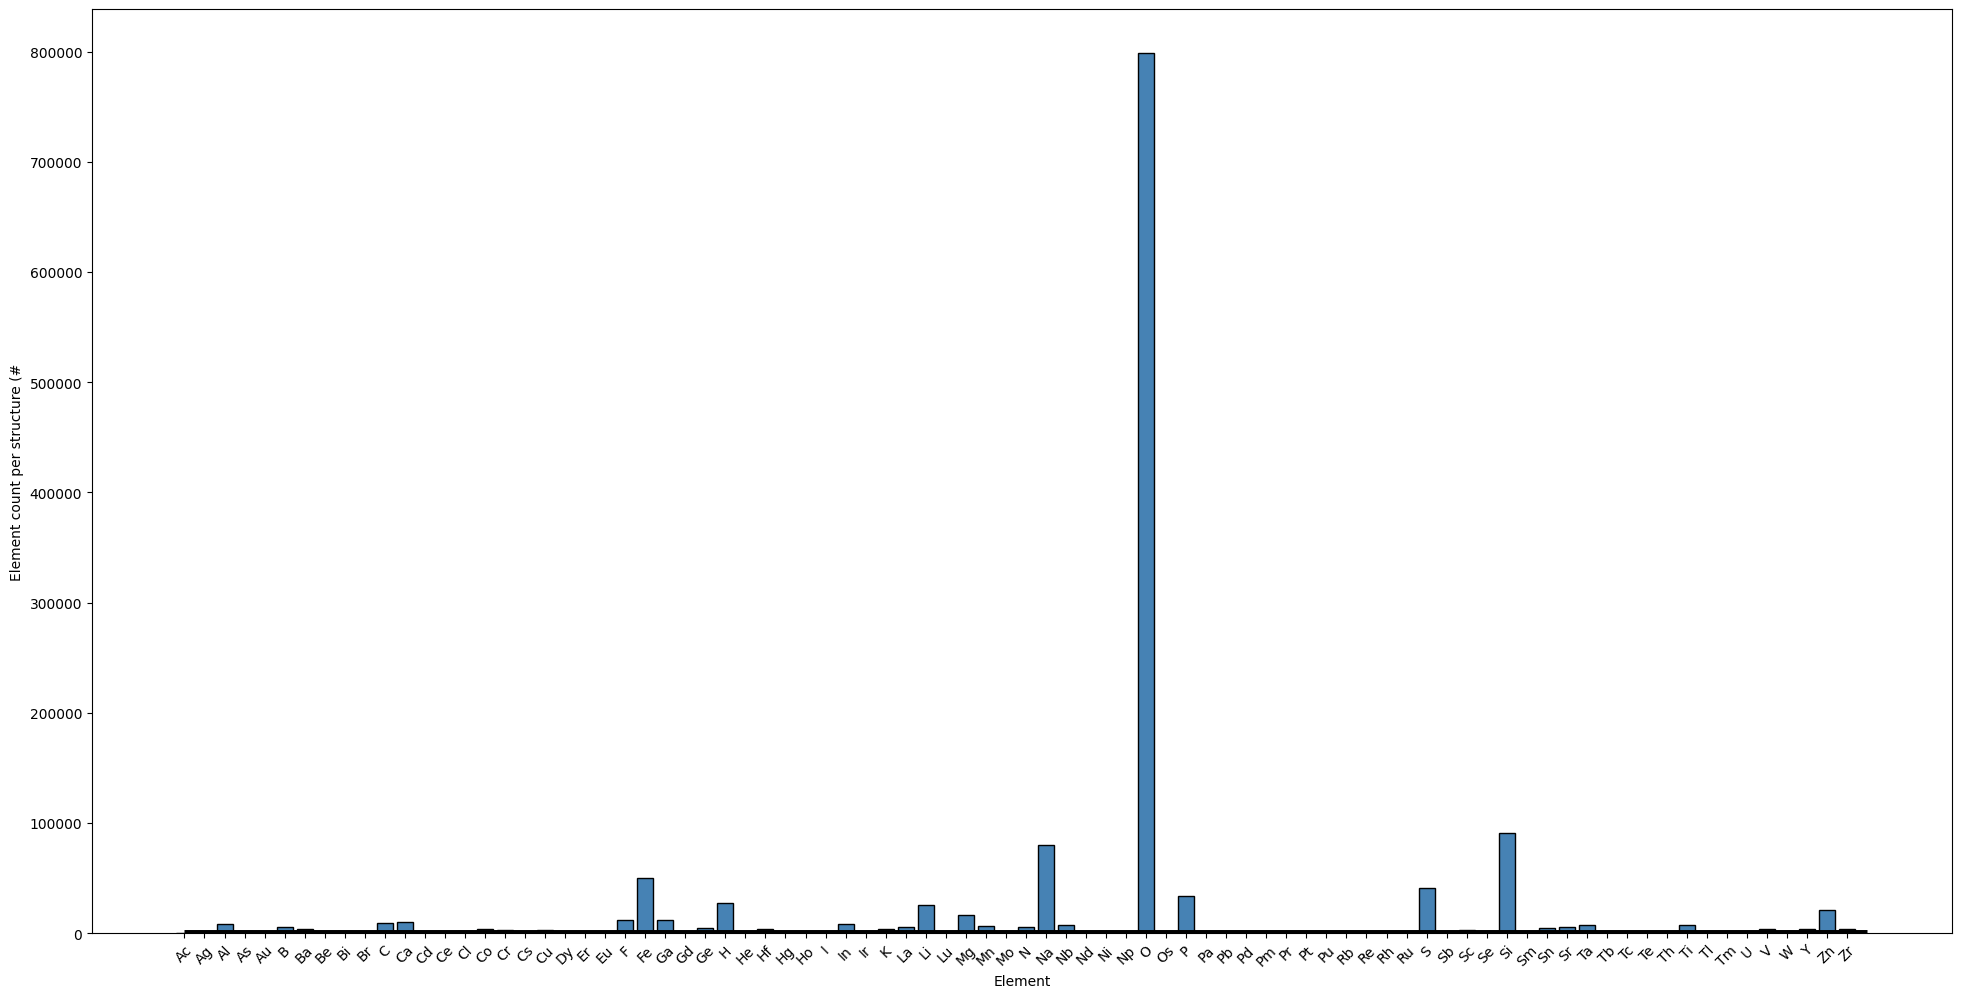

In [ ]:
# Plot atom counts, only considering if atom of that type is in the crystal
fig, ax = plt.subplots(figsize=[24,12], dpi=100)
ax.bar(crystal_atom_counts.index, crystal_atom_counts.values, edgecolor='k', color='steelblue')
plt.xticks(rotation=45)
ax.set_xlabel('Element')
ax.set_ylabel('Element count per structure (#')
ax.hlines(y=300, xmin=0, xmax=len(crystal_atom_counts.index), color='k', linewidth=5)

In [ ]:
# Only choose structures with elements that are well represented in the dataset
n_crystals_cutoff = 300
elements = [key for key in crystal_atom_counts.keys() if crystal_atom_counts[key] >= n_crystals_cutoff]
print(f"Allowed Elements: {elements}")
print(f"Number of Elements: {len(elements)}")

# Lets now filter the structures
mask = [row[1].name for row in dfC.iterrows() if np.all(np.isin(list(row[1].composition_dict.keys()), elements))]

Allowed Elements: ['Ag', 'Al', 'As', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Ho', 'I', 'In', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'O', 'P', 'Pb', 'Pr', 'Rb', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Te', 'Ti', 'Tl', 'V', 'W', 'Y', 'Zn', 'Zr']
Number of Elements: 63


In [ ]:
filtered = dfC.loc[mask].drop_duplicates(subset='material_id')
filtered = filtered.loc[filtered.band_gap > 0]
filtered

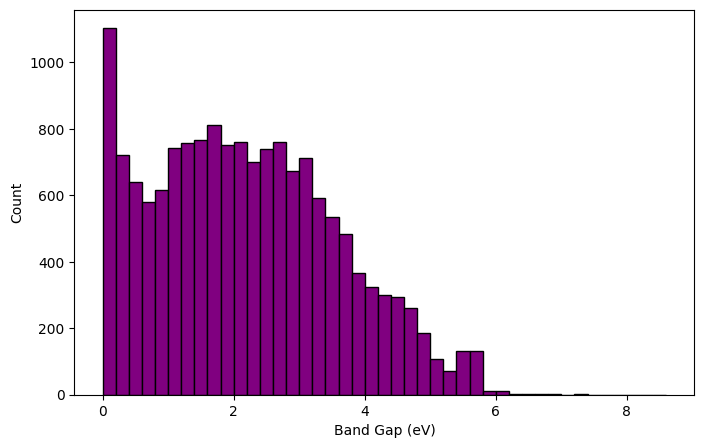

In [ ]:
# Lets take a look at the distribution of band gaps
fig, ax = plt.subplots(figsize=[8, 5], dpi=100)
ax.hist(filtered.band_gap, color='purple', edgecolor='k', bins=np.linspace(0, 8.6, 44))
ax.set_xlabel('Band Gap (eV)')
ax.set_ylabel('Count')
plt.savefig('filtered_data_bandgap_distribution.png')

In [ ]:
filtered[['material_id', 'comp', 'band_gap']].to_json(orient='records')

In [ ]:
filtered.to_csv('GaInZnSiFe_oxides_filtered_300.csv', index=False)

# Getting Materials Representation
To be used as training features

## From MatMiner's Presets

In [ ]:
# Featurising 'filtered' dataframe based on composition
amorphous_oxides = StrToComposition().featurize_dataframe(filtered,"comp")
# Define the featuriser
ep_feat_magpie = ElementProperty.from_preset(preset_name="magpie")
ep_feat_matscholar = ElementProperty.from_preset(preset_name="matscholar_el")

X_desc_magpie = ep_feat_magpie.featurize_dataframe(amorphous_oxides,col_id="comp").iloc[:,6:]
X_desc_matscholar = ep_feat_matscholar.featurize_dataframe(amorphous_oxides, col_id="comp").iloc[:,6:]
# The shape indicates how many columns are included within each feature type
print(X_desc_magpie.shape)
print(X_desc_matscholar.shape)
X_desc_magpie.head(5), X_desc_matscholar.head(5)

In [ ]:
# Dropping columns (descriptors) with nan values (ensure dtype is float32)

X_desc_matscholar = X_desc_matscholar.dropna(how='any',axis=1)
columns = X_desc_matscholar.iloc[:, 5:].columns
X_desc_matscholar = pd.DataFrame(np.array(X_desc_matscholar.iloc[:, 5:],dtype=np.float32),columns=columns)

X_desc_magpie = X_desc_magpie.dropna(how='any',axis=1)
columns = X_desc_magpie.iloc[:, 5:].columns
X_desc_magpie = pd.DataFrame(np.array(X_desc_magpie.iloc[:, 5:],dtype=np.float32),columns=columns)

In [9]:
# Generating train and test splits

X_train_magpie, X_test_magpie, y_train_magpie, y_test_magpie = train_test_split(X_desc_magpie, amorphous_oxides.band_gap.values, test_size=0.2, random_state=32)
X_train_matscholar, X_test_matscholar, y_train_matscholar, y_test_matscholar = train_test_split(X_desc_matscholar, y, test_size=0.2, random_state=32)

## Sine Matrix

In [90]:
df = pd.read_csv('GaInZnSiFe_oxides_filtered_300.csv', usecols=[0,7])
# df = df[df.material_id!='mp-2714260'].reset_index(drop=True)
print(df.shape)
df.head()

(15648, 2)


,material_id,band_gap
0,mp-1262161,2.8233
1,mp-2714778,3.6423
2,mp-2716516,2.5221
3,mp-2239948,2.1823
4,mp-540945,3.2395


In [ ]:
## SKIP THIS CELL if JSON file 'GaInZnSiFe_oxides_filtered_300_structures.json' has been generated
get_structures_from_mp_api(material_ids=df['material_id'].tolist(), json_save_filename='GaInZnSiFe_oxides_filtered_300_structures.json')

In [ ]:
# Read the JSON file 
with open('GaInZnSiFe_oxides_filtered_300_structures.json','rb') as f:
    st2 = json.load(f)

eigen_list = []
for structure in st2:
    structure = Structure.from_dict(structure)                                  # recreate pymatgen's Structure object from the dict stored in the JSON file
    eigen = get_eigen_matrix(structure=structure, matrix_fn=get_sine_matrix)    # get the eigen values of the structure's sine matrix
    eigen_list.append(eigen)

eigenDF = pd.DataFrame(eigen_list).astype(np.float64).fillna(0)

## Reduce the dimensionality of the eigenvalues data with PCA
ss = StandardScaler()
pca = PCA(n_components=0.95)        # retain >=95% explained variance after PCA

eigen_PCA_DF = pd.DataFrame(pca.fit_transform(ss.fit_transform(eigenDF.values)))
eigen_PCA_DF.head()

# Initial Screening for Selecting Algorithm and Features

Screen by building model without hyperparameter tuning on the 3 set of features
This follows a full factorial design of experimentation and we can select the combination of algorithm and feature set that gives the lowest test MSE as candidate for further tuning

## Sine Matrix Representation on XGBRegressor, SVR, and RandomForestRegressor

use 5-fold cross validation to make sure screening results is not affected by randomness during train test split

In [ ]:
xgbr = XGBRegressor()

cv_results = cross_validate(xgbr, eigen_PCA_DF, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  1.8031077261071649
5-fold test MSE average:  2.1280317484485427


In [ ]:
svr = SVR(kernel='rbf')

cv_results = cross_validate(svr, eigen_PCA_DF, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  1.9612314055882092
5-fold test MSE average:  2.162561438985679


In [ ]:
rf = RandomForestRegressor()
cv_results = cross_validate(rf, eigen_PCA_DF, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  1.8225090968076318
5-fold test MSE average:  2.0961524963037093


## Magpie data on XGBRegressor, SVR, and RandomForestRegressor

use 5-fold cross validation to make sure screening results is not affected by randomness during train test split

In [ ]:
xgbr = XGBRegressor()

cv_results = cross_validate(xgbr, X_desc_magpie, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  0.23693745060440857
5-fold test MSE average:  0.9799510295760886


In [ ]:
rf = RandomForestRegressor()

cv_results = cross_validate(rf, X_desc_magpie, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  0.1876310407029187
5-fold test MSE average:  0.9461724896194651


In [ ]:
svr = SVR(kernel='rbf')

cv_results = cross_validate(svr, X_desc_magpie, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  1.8151932755895284
5-fold test MSE average:  2.0858977640735823


## MatScholar data on XGBRegressor, SVR, and RandomForestRegressor

use 5-fold cross validation to make sure screening results is not affected by randomness during train test split

In [ ]:
xgbr = XGBRegressor()

xgb_cv_results = cross_validate(xgbr, X_desc_matscholar, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold MatScholar train MSE average: ', -np.mean(xgb_cv_results['train_score']))
print('5-fold MatScholar test MSE average: ', -np.mean(xgb_cv_results['test_score']))

5-fold MatScholar train MSE average:  0.1943903664044695
5-fold MatScholar test MSE average:  1.016627671119288


In [65]:
rf = RandomForestRegressor()

cv_results = cross_validate(xgbr, X_desc_matscholar, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  0.423744041932665
5-fold test MSE average:  1.6479751489118573


In [66]:
svr = SVR(kernel='rbf')

cv_results = cross_validate(svr, X_desc_matscholar, df.band_gap.values, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('5-fold train MSE average: ', -np.mean(cv_results['train_score']))
print('5-fold test MSE average: ', -np.mean(cv_results['test_score']))

5-fold train MSE average:  1.340525131725069
5-fold test MSE average:  1.5630407383434695


Based on these results, RandomForestRegressor with Magpie features seems to give the lowest test MSE. Therefore we will select it for hyper parameter tuning

# Hyper Parameter Tuning

In [64]:
#Note: Not sure if I need to perform the train_test_split again
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [8, 10, 12]}

grid_search2 = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid=param_grid,cv=KFold(n_splits=5, shuffle=True, random_state=32))
# grid_search.fit(X_train_megnet, y_train_megnet)
grid_search2.fit(X_desc_magpie, df.band_gap)
grid_search2.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': None,
 'min_samples_leaf': 6,
 'min_samples_split': 8}

## Top 10 Most Important Features

In [ ]:
sorted([(x,y) for x,y in zip(X_desc_magpie.columns, grid_search2.best_estimator_.feature_importances_)], key=lambda x:x[1])[::-1][:10]

[('MagpieData maximum NdValence', 0.09528423838728335),
 ('MagpieData range NdValence', 0.07649851633364092),
 ('MagpieData avg_dev GSmagmom', 0.05690767572818065),
 ('MagpieData avg_dev MendeleevNumber', 0.03863112061491424),
 ('MagpieData mean MendeleevNumber', 0.03151520602693358),
 ('MagpieData mean NUnfilled', 0.028799652186475642),
 ('MagpieData mean GSmagmom', 0.02551203822933436),
 ('MagpieData avg_dev NUnfilled', 0.02385596500892655),
 ('MagpieData mean MeltingT', 0.023852139641543486),
 ('MagpieData mean GSbandgap', 0.023557805184081956)]

## Actual vs Predicted Plot

### Before Tuning

In [44]:
rf_before_tuning = RandomForestRegressor(random_state=42)
rf_before_tuning.fit(X_train_magpie, y_train_magpie)
rf_before_tr_preds_magpie = rf_before_tuning.predict(X_train_magpie)
rf_before_te_preds_magpie = rf_before_tuning.predict(X_test_magpie)

best feature train MSE: 0.383
best feature test MSE: 1.203
best feature train MAE: 0.421
best feature test MAE: 0.794


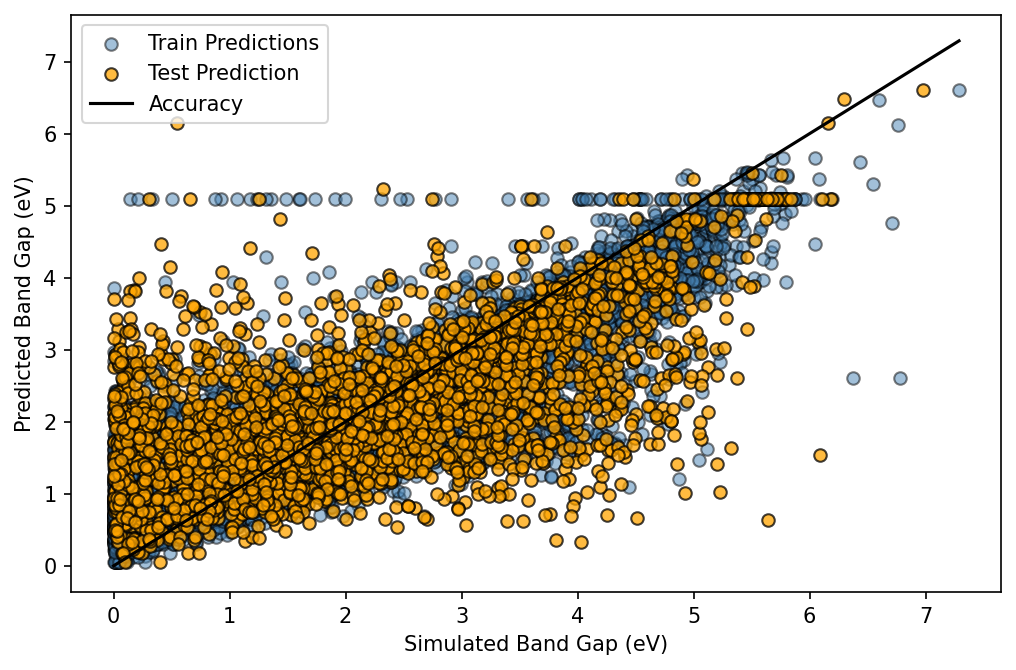

In [45]:
fig, ax = plt.subplots(figsize=[8, 5], dpi=150)
acc = np.linspace(0, np.max(np.concatenate([y_train_magpie, rf_before_tr_preds_magpie, y_test_magpie, rf_before_te_preds_magpie])), 1000)
ax.scatter(y_train_magpie, rf_before_tr_preds_magpie, color='steelblue', edgecolor='k', alpha=0.5, label='Train Predictions')
ax.scatter(y_test_magpie, rf_before_te_preds_magpie, color='orange', edgecolor='k', alpha=0.75, label='Test Prediction')
ax.plot(acc, acc, label='Accuracy', color='black')
ax.set_xlabel('Simulated Band Gap (eV)')
ax.set_ylabel('Predicted Band Gap (eV)')
plt.legend()
print(f'best feature train MSE: {mse(y_train_magpie, rf_before_tr_preds_magpie):.3f}')
print(f'best feature test MSE: {mse(y_test_magpie, rf_before_te_preds_magpie):.3f}')
print(f'best feature train MAE: {mae(y_train_magpie, rf_before_tr_preds_magpie):.3f}')
print(f'best feature test MAE: {mae(y_test_magpie, rf_before_te_preds_magpie):.3f}')
# plt.savefig('XGB_actual_vs_predicted_plot.png')

### After Tuning

In [83]:
rf2 = RandomForestRegressor(max_depth=50, max_features=None, min_samples_leaf=6, min_samples_split=8, random_state=42)
rf2.fit(X_train_magpie, y_train_magpie)
rf2_tr_preds_magpie = rf2.predict(X_train_magpie)
rf2_te_preds_magpie = rf2.predict(X_test_magpie)

best feature train MSE: 0.628
best feature test MSE: 1.157
best feature train MAE: 0.580
best feature test MAE: 0.794


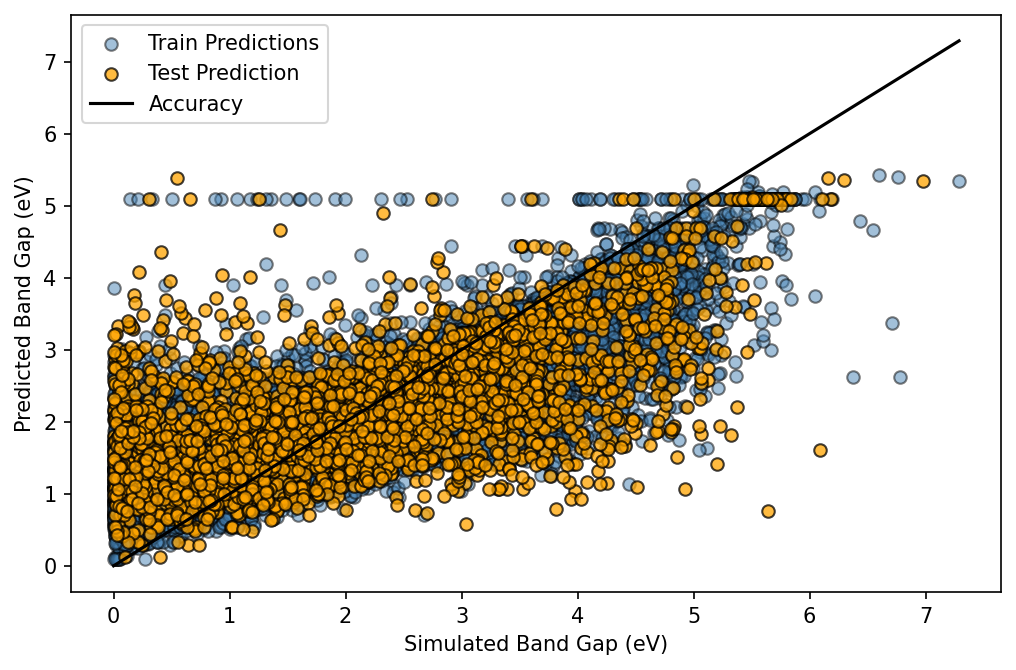

In [84]:
fig, ax = plt.subplots(figsize=[8, 5], dpi=150)
acc = np.linspace(0, np.max(np.concatenate([y_train_magpie, rf2_tr_preds_magpie, y_test_magpie, rf2_te_preds_magpie])), 1000)
ax.scatter(y_train_magpie, rf2_tr_preds_magpie, color='steelblue', edgecolor='k', alpha=0.5, label='Train Predictions')
ax.scatter(y_test_magpie, rf2_te_preds_magpie, color='orange', edgecolor='k', alpha=0.75, label='Test Prediction')
ax.plot(acc, acc, label='Accuracy', color='black')
ax.set_xlabel('Simulated Band Gap (eV)')
ax.set_ylabel('Predicted Band Gap (eV)')
plt.legend()
print(f'best feature train MSE: {mse(y_train_magpie, rf2_tr_preds_magpie):.3f}')
print(f'best feature test MSE: {mse(y_test_magpie, rf2_te_preds_magpie):.3f}')
print(f'best feature train MAE: {mae(y_train_magpie, rf2_tr_preds_magpie):.3f}')
print(f'best feature test MAE: {mae(y_test_magpie, rf2_te_preds_magpie):.3f}')
# plt.savefig('XGB_actual_vs_predicted_plot.png')

# Checking Overfitting / Underfitting

## Learning Curve

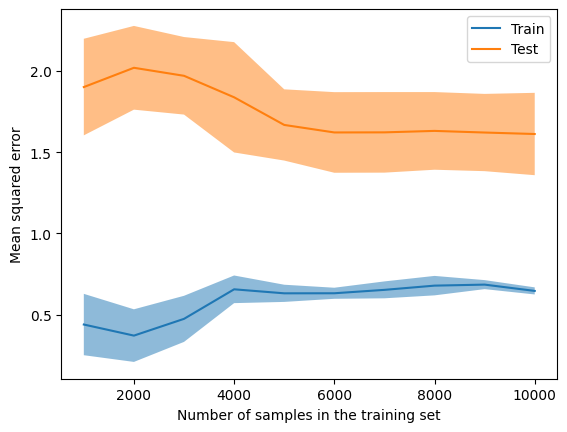

In [89]:
LearningCurveDisplay.from_estimator(rf2, X_desc_magpie,df.band_gap.values, train_sizes=np.arange(1000,10432,1000),cv=3, scoring= "neg_mean_squared_error", negate_score=True)

The model seems to stop learning beyond 6000 data point, it suggests that this model is underfit. additional training data may not help to improve the accuracy of the model as this model is too simple to model the complex phenomena such as band gap.

In the future, we might need to look at graph representation of the crystal structure as features and make use of graph neural network technique that has been shown by <a href="https://www.nature.com/articles/s41586-023-06735-9">DeepMind's GNoMe</a> model to be able to predict formation energy.